# Instalando paquetes!

In [2]:
import sys
!{sys.executable} -m pip install numpy

     |████████████████████████████████| 15.7 MB 30.8 MB/s eta 0:00:01     |████████████████████████████████| 15.7 MB 30.8 MB/s            


In [3]:
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pycaret

     |████████████████████████████████| 11.5 MB 26.3 MB/s            
     |████████████████████████████████| 503 kB 119.6 MB/s            
     |████████████████████████████████| 10.3 MB 32.5 MB/s            
     |████████████████████████████████| 1.2 MB 104.2 MB/s            
     |████████████████████████████████| 3.1 MB 127.6 MB/s            
     |████████████████████████████████| 266 kB 35.8 MB/s            
     |████████████████████████████████| 6.8 MB 20.2 MB/s            
     |████████████████████████████████| 10.5 MB 40.0 MB/s            
     |████████████████████████████████| 1.3 MB 128.3 MB/s            
     |████████████████████████████████| 1.5 MB 124.0 MB/s            
     |████████████████████████████████| 25.8 MB 135.2 MB/s            
     |████████████████████████████████| 271 kB 134.8 MB/s            
     |████████████████████████████████| 167 kB 111.5 MB/s            
     |████████████████████████████████| 113 kB 148.4 MB/s            
  Preparing metadata 

## Librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import datetime
import pycaret
import pycaret.anomaly as pyano
import pycaret.classification as pyclf
import scipy.stats as stats
import statistics

## Preprocesando

In [4]:
#Lectura
data = pd.read_csv('results.csv', sep=';')
#Columnas
data.columns = ['Fecha','IP Origen','IP Destino','Servicio','Accion','doc_count']
#Serie a Str
data['IP Destino'] = data['IP Destino'].map(str)
data['IP Origen'] = data['IP Origen'].map(str)
#De Epochs a Fecha
data['Fecha'] = data['Fecha'].astype(str).str[:-3]
data['Fecha'] = pd.to_datetime(data['Fecha'], unit = 's')
# Transformamos la columna Servicio a Puerto
def limpiar_servicio(servicio):
    string=re.search('\(([^)]+)', servicio).group(1)
    return string
data['Servicio']=data['Servicio'].apply(limpiar_servicio)

df1=data

# Creamos IP TYPE con el fin de diferenciar nuestra clasificación

# ip priv
# https://es.wikipedia.org/wiki/Red_privada
df1['IP Destino']=df1['IP Destino'].map(str)

df1.loc[(df1['IP Destino'].str.startswith('10.', na = False) == True)|
        (df1['IP Destino'].str.startswith('169.254', na = False) == True)|
        (df1['IP Destino'].str.startswith(('172.16','172.17','172.18','172.19','172.20','172.21','172.22', '172.23','172.24','172.25','172.26','172.27','172.28','172.29','172.30','172.31'), na = False) == True)|
        (df1['IP Destino'].str.startswith('192.168', na = False) == True), 'ip_type_destino'] = 'Int'
df1['ip_type_destino'] = df1['ip_type_destino'].fillna('Ext')


# Creamos Port Lvl con el fin de identificar los puertos comunmente atacados:

df1['Servicio']=df1['Servicio'].map(str)

df1.loc[
    # FTP 
        (df1['Servicio'] =='20')|
        (df1['Servicio'] =='21')|
    # SSH
        (df1['Servicio'] == '22')|
    # Telnet
         (df1['Servicio'] == '23')|
    # SMTP -> Por e-mail, spam
        (df1['Servicio'] == '25')|
    # DNS -> Ataques DDoS
         (df1['Servicio'] == '53')|
         (df1['Servicio'] == '88')|
         (df1['Servicio'] == '445')|
    #
         (df1['Servicio'] == '110')|
    #
         (df1['Servicio'] == '135')|
    #
         (df1['Servicio'] == '137')|
    #
         (df1['Servicio'] == '138')|
    # NetBIOS -> Impresora
         (df1['Servicio'] == '139')|
    # SQL Server y MySQL  puertos por default -> distribución de Malware
         (df1['Servicio'] == '1433')|
    #
         (df1['Servicio'] == '1434')|
    #
         (df1['Servicio'] == '3306')|
    # Postgres SQL
         (df1['Servicio'] == '5432')|
    # Escritorio remoto
         (df1['Servicio'] == '3389'), 'Port Lvl'] = 'Peligroso'

df1['Port Lvl'] = df1['Port Lvl'].fillna('Seguro')

# Para identificar el estatus 
df1['Accion']=df1['Accion'].map(str)
df1.loc[
    # No pasó el firewall
        (df1['Accion'] == 'drop')|
        (df1['Accion'] == 'stop')|
        (df1['Accion'] == 'reject'),
    'Action'] = 'No Paso'

df1['Action'] = df1['Action'].fillna('Paso')
df1['aux_indx'] = df1.index

In [5]:
df1['IP Origen']=df1['IP Origen'].map(str)
df1.loc[(df1['IP Origen'].str.startswith('10.', na = False) == True)|
        (df1['IP Origen'].str.startswith('169.254', na = False) == True)|
        (df1['IP Origen'].str.startswith(('172.16','172.17','172.18','172.19','172.20','172.21','172.22', '172.23','172.24','172.25','172.26','172.27','172.28','172.29','172.30','172.31'), na = False) == True)|
        (df1['IP Origen'].str.startswith('192.168', na = False) == True), 'ip_type_origen'] = 'Int'
df1['ip_type_origen'] = df1['ip_type_origen'].fillna('Ext')

In [6]:
df1.loc[(df1['ip_type_origen']=='Int') & 
        (df1['ip_type_destino']=='Int'), 'ip_type_interaccion']='II' # Mayor influencia
df1.loc[(df1['ip_type_origen']=='Int') & (df1['ip_type_destino']=='Ext'), 'ip_type_interaccion']='IE'
df1.loc[(df1['ip_type_origen']=='Ext') & (df1['ip_type_destino']=='Int'), 'ip_type_interaccion']='EI'
df1.loc[(df1['ip_type_origen']=='Ext') & (df1['ip_type_destino']=='Ext'), 'ip_type_interaccion']='EE'

### Filtramos por II, Paso, Peligroso

In [7]:
df1 = df1[df1['ip_type_interaccion']=='II']
data1 = df1[['Fecha','ip_type_interaccion', 'Action', 'Port Lvl', 'doc_count','aux_indx']]
data1 = data1[data1['Action']=='Paso']
data1 = data1[data1['Port Lvl']== 'Peligroso']

In [8]:
data1.head()

,Fecha,ip_type_interaccion,Action,Port Lvl,doc_count,aux_indx
163,2021-09-16 02:00:00,II,Paso,Peligroso,8,163
165,2021-09-16 02:00:00,II,Paso,Peligroso,1,165
232,2021-09-16 02:00:00,II,Paso,Peligroso,8,232
233,2021-09-16 02:00:00,II,Paso,Peligroso,8,233
234,2021-09-16 02:00:00,II,Paso,Peligroso,8,234


### Creamos un DataFrame para trabajarlo sin desordenar nuestro primer filtro

In [9]:
working_data =  data1[['Fecha', 'doc_count']]
working_data = working_data.groupby('Fecha').mean()

### Medidas estadísticas para entender un poco el comportamiento

In [104]:
statistics.mean(working_data['doc_count'])

109.03705226194342

In [251]:
zscore = stats.zscore(working_data)

### Graficando la media de conexiones por hora 

Text(0, 0.5, 'Conexiones II - Peligroso - Paso')

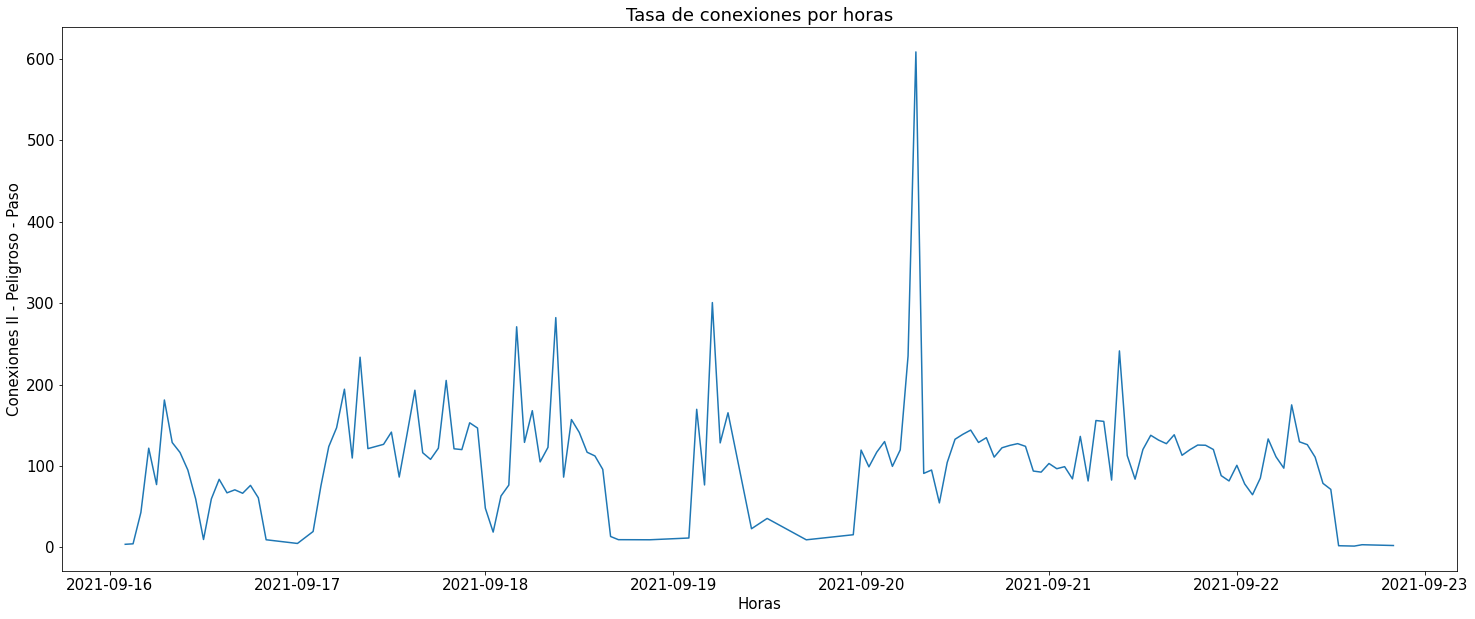

In [262]:
plt.figure(figsize=(25,10))
plt.plot(working_data)
plt.title('Tasa de conexiones por horas')
plt.xlabel('Horas')
plt.ylabel('Conexiones II - Peligroso - Paso')

In [10]:
working_data[working_data['doc_count']>=200]

,doc_count
Fecha,
2021-09-17 08:00:00,233.738095
2021-09-17 19:00:00,205.216049
2021-09-18 04:00:00,271.127820
2021-09-18 09:00:00,282.383886
2021-09-19 05:00:00,300.863095
2021-09-20 06:00:00,235.282946
2021-09-20 07:00:00,608.793028
2021-09-21 09:00:00,241.501931


In [11]:
print(working_data.to_string())

                      doc_count
Fecha                          
2021-09-16 02:00:00    3.916168
2021-09-16 03:00:00    4.506494
2021-09-16 04:00:00   43.045845
2021-09-16 05:00:00  121.983871
2021-09-16 06:00:00   77.271949
2021-09-16 07:00:00  181.191964
2021-09-16 08:00:00  128.948905
2021-09-16 09:00:00  116.705411
2021-09-16 10:00:00   95.090656
2021-09-16 11:00:00   59.565418
2021-09-16 12:00:00    9.790685
2021-09-16 13:00:00   59.653992
2021-09-16 14:00:00   83.737806
2021-09-16 15:00:00   67.143395
2021-09-16 16:00:00   70.829020
2021-09-16 17:00:00   66.604570
2021-09-16 18:00:00   76.300552
2021-09-16 19:00:00   61.063912
2021-09-16 20:00:00    9.491749
2021-09-17 00:00:00    4.954023
2021-09-17 02:00:00   19.633333
2021-09-17 03:00:00   75.788932
2021-09-17 04:00:00  123.937669
2021-09-17 05:00:00  147.106529
2021-09-17 06:00:00  194.444954
2021-09-17 07:00:00  109.913043
2021-09-17 08:00:00  233.738095
2021-09-17 09:00:00  121.444196
2021-09-17 10:00:00  124.065463
2021-09-

### Vemos si con el modelo de Isolation Forest conseguimos encontrar lo que podemos observar del gráfico

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

### Escalamos los datos y los dejamos trabajables por el modelo de ML

In [15]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(working_data['doc_count'].values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [35]:
outliers_fraction = 0.05

In [36]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 

IsolationForest(contamination=0.05)

### Anomalías detectadas!

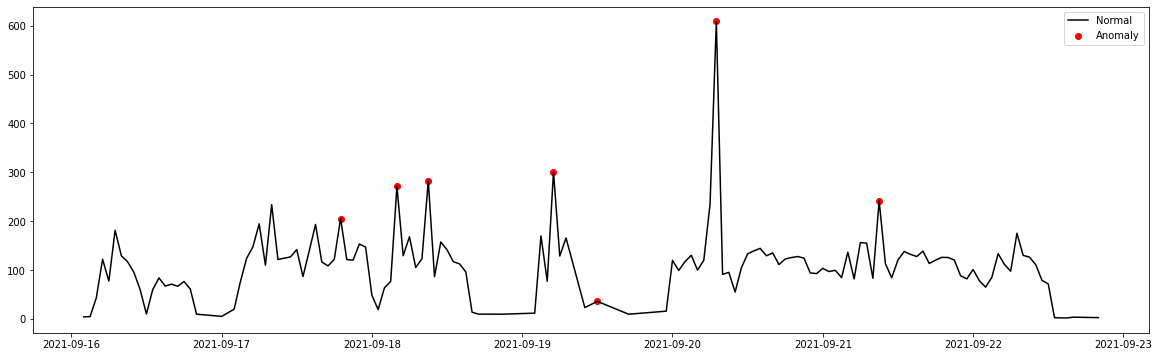

In [37]:
working_data['anomaly'] = model.predict(data)

# visualizando
fig, ax = plt.subplots(figsize=(20,6))

a = working_data.loc[working_data['anomaly'] == -1, ['doc_count']] #anomaly

ax.plot(working_data.index, working_data['doc_count'], color='black', label = 'Normal')
ax.scatter(a.index,a['doc_count'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

### Parece que al menos vio las anomalías mas fuertes, así que sería un modelo aceptable.

In [38]:
working_data[working_data['anomaly']==-1]

,doc_count,anomaly
Fecha,,
2021-09-17 19:00:00,205.216049,-1
2021-09-18 04:00:00,271.127820,-1
2021-09-18 09:00:00,282.383886,-1
2021-09-19 05:00:00,300.863095,-1
2021-09-19 12:00:00,35.700000,-1
2021-09-20 07:00:00,608.793028,-1
2021-09-21 09:00:00,241.501931,-1


### Veamos como detecta las anomalías con un set mas grande
#### Ahora usamos el set completo de II-Paso-Peligroso

In [39]:
wd = data1[['Fecha', 'doc_count','aux_indx']]
wd = wd.set_index('Fecha')
np_scaled2 = scaler.fit_transform(wd['doc_count'].values.reshape(-1, 1))
data2 = pd.DataFrame(np_scaled2)

In [40]:
model2 =  IsolationForest(contamination=outliers_fraction)
model2.fit(data2) 

IsolationForest(contamination=0.05)

In [41]:
wd['anomaly'] = model2.predict(data2)

### Detectó varias anomalías, veamos si podemos visualizarlas

In [42]:
wd['anomaly'].value_counts()

 1    215558
-1     11342
Name: anomaly, dtype: int64

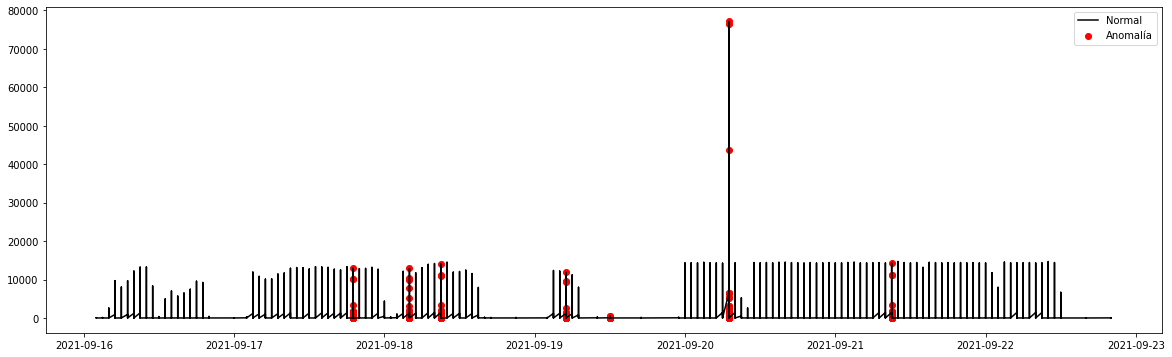

In [43]:
fig, ax = plt.subplots(figsize=(20,6))

a = wd.loc[working_data['anomaly'] == -1, ['doc_count']] #Anomalia

ax.plot(wd.index, wd['doc_count'], color='black', label = 'Normal')
ax.scatter(a.index,a['doc_count'], color='red', label = 'Anomalía')
plt.legend()
plt.show();

### Veamos los datos para intentar entender cual es su umbral de anomalía

In [44]:
print(wd[wd['anomaly']==-1].to_string())

                     doc_count  aux_indx  anomaly
Fecha                                            
2021-09-16 04:00:00        668      4356       -1
2021-09-16 04:00:00       2585      4362       -1
2021-09-16 04:00:00       1636      4364       -1
2021-09-16 04:00:00       2095      4366       -1
2021-09-16 05:00:00        923     33263       -1
2021-09-16 05:00:00        929     33264       -1
2021-09-16 05:00:00        926     33265       -1
2021-09-16 05:00:00        927     33266       -1
2021-09-16 05:00:00       2026     33476       -1
2021-09-16 05:00:00       9719     33483       -1
2021-09-16 05:00:00       7316     33485       -1
2021-09-16 05:00:00       8283     33487       -1
2021-09-16 05:00:00       1438     34367       -1
2021-09-16 06:00:00        770     77211       -1
2021-09-16 06:00:00        767     77212       -1
2021-09-16 06:00:00        768     77213       -1
2021-09-16 06:00:00        763     77214       -1
2021-09-16 06:00:00       1679     77392       -1


In [45]:
wd[wd['anomaly']==-1]['doc_count'].describe()

count    11342.000000
mean      1245.379386
std       2122.616185
min        549.000000
25%        701.000000
50%        809.000000
75%        999.000000
max      77143.000000
Name: doc_count, dtype: float64

### Graficamos la media por hora de las anomalías
#### Podemos ver que incluso dentro de las anomalías hay una anomalía!

Text(0, 0.5, 'doc_count medio de Anomalías II - Peligroso - Paso')

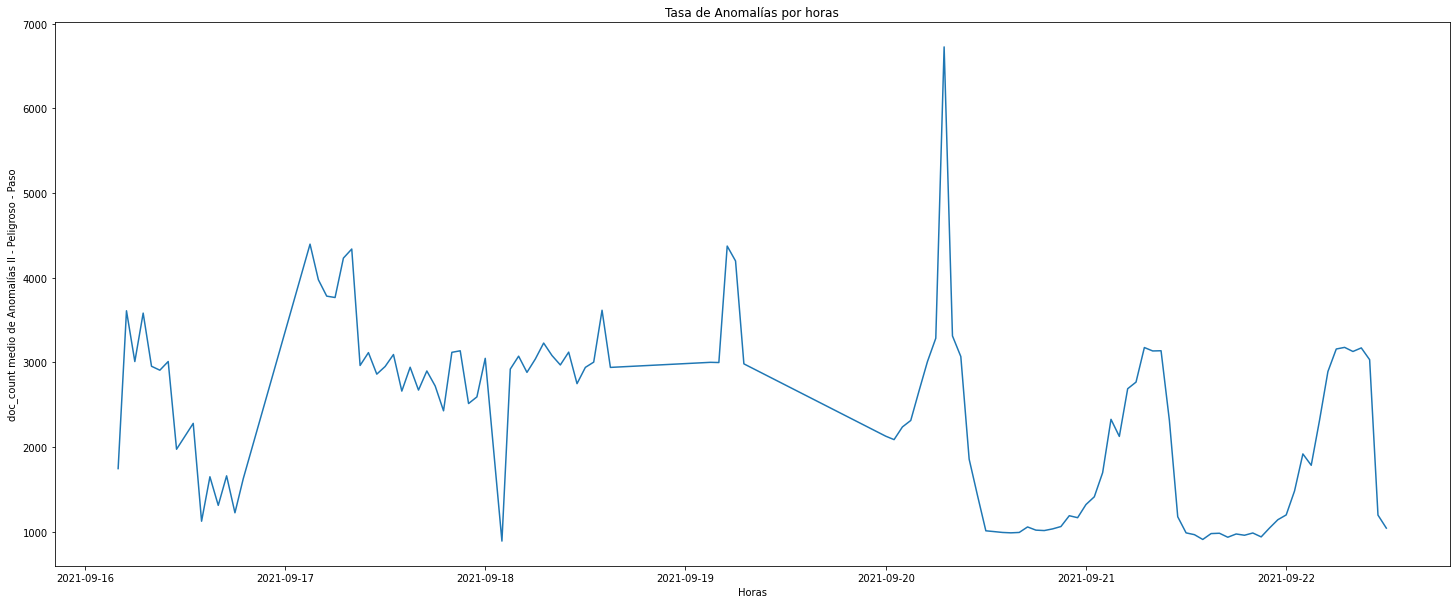

In [46]:
toplot = wd[wd['anomaly']==-1]['doc_count'].groupby('Fecha').mean()
plt.figure(figsize=(25,10))
plt.plot(toplot)
plt.title('Tasa de Anomalías por horas')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías II - Peligroso - Paso')

#### Veamos los datos enteros a los que corresponden estas anomalías!

In [47]:
anomaly_data = wd[wd['anomaly']==-1]
anomaly_data = anomaly_data.reset_index()
lista = anomaly_data['aux_indx'].to_list()

In [48]:
df1.loc[lista]

,Fecha,IP Origen,IP Destino,Servicio,Accion,doc_count,ip_type_destino,Port Lvl,Action,aux_indx,ip_type_origen,ip_type_interaccion
4356,2021-09-16 04:00:00,10.20.3.23,10.20.1.30,53,accept,668,Int,Peligroso,Paso,4356,Int,II
4362,2021-09-16 04:00:00,10.100.5.80,10.20.1.30,53,accept,2585,Int,Peligroso,Paso,4362,Int,II
4364,2021-09-16 04:00:00,10.100.5.159,10.20.1.30,53,accept,1636,Int,Peligroso,Paso,4364,Int,II
4366,2021-09-16 04:00:00,10.100.5.169,10.20.1.30,53,accept,2095,Int,Peligroso,Paso,4366,Int,II
33263,2021-09-16 05:00:00,10.100.5.187,10.15.17.53,22,accept,923,Int,Peligroso,Paso,33263,Int,II
...,...,...,...,...,...,...,...,...,...,...,...,...
7023319,2021-09-22 12:00:00,172.16.8.202,10.20.1.30,53,accept,751,Int,Peligroso,Paso,7023319,Int,II
7023320,2021-09-22 12:00:00,172.16.8.202,10.20.1.30,53,decrypt,750,Int,Peligroso,Paso,7023320,Int,II
7025357,2021-09-22 12:00:00,172.16.8.189,10.20.1.31,53,accept,740,Int,Peligroso,Paso,7025357,Int,II
7025358,2021-09-22 12:00:00,172.16.8.189,10.20.1.31,53,decrypt,739,Int,Peligroso,Paso,7025358,Int,II


### Y de donde vienen y como se distribuyen?

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

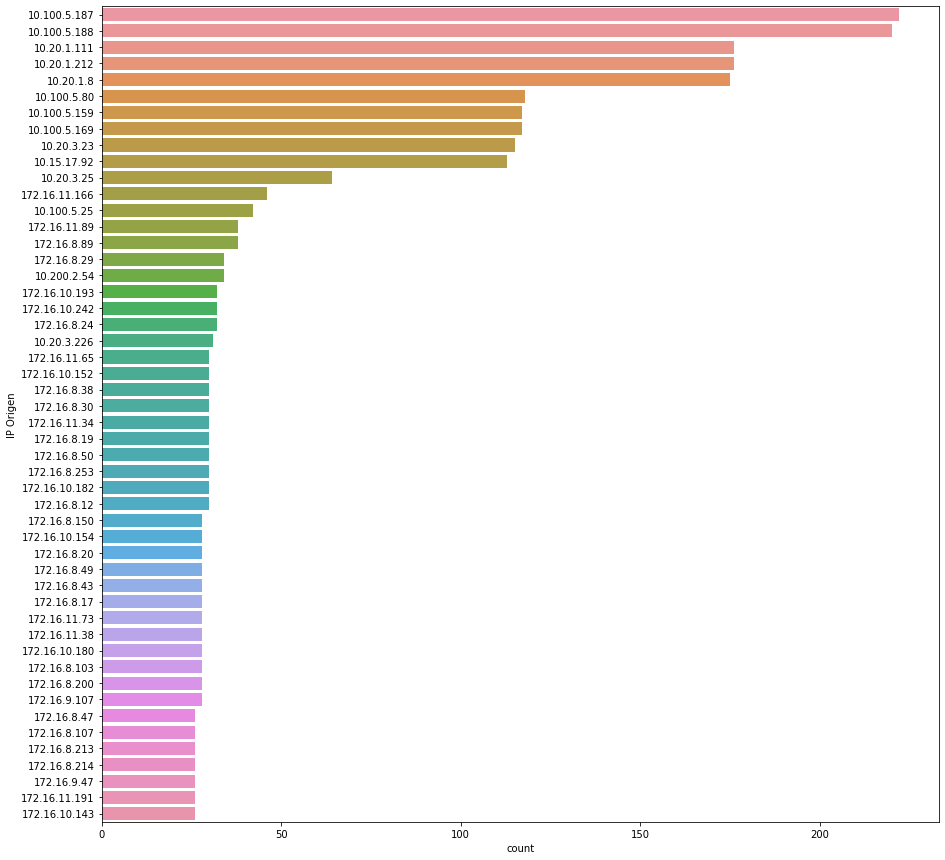

In [49]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = df1.loc[lista],
             order = df1.loc[lista]['IP Origen'].value_counts().iloc[:50].index)

### Hacia donde van y como se distribuyen?

<AxesSubplot:xlabel='count', ylabel='IP Destino'>

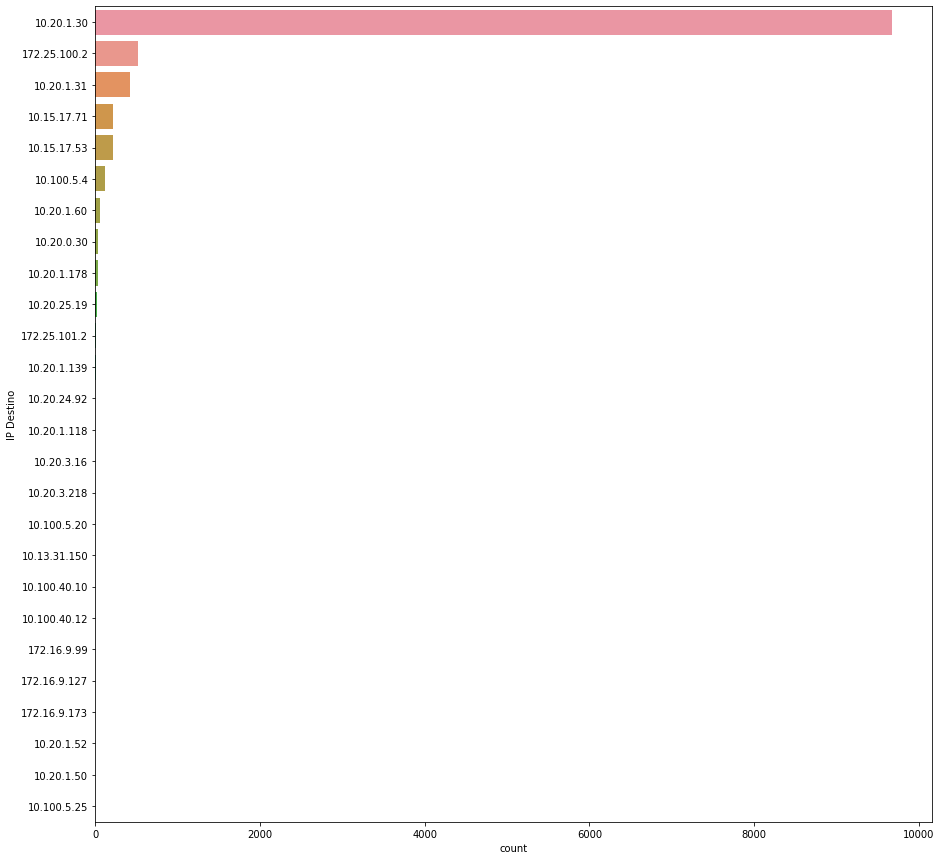

In [50]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.countplot(y='IP Destino', data = df1.loc[lista],
             order = df1.loc[lista]['IP Destino'].value_counts().iloc[:50].index)

## Ahora usaremos un data set mas grande para ver si podemos detectar mas anomalías y encontrar comportamientos relevantes, ahora solo filtramos Interno - Interno.
#### Usaremos 780mil datos ahora!

In [51]:
wd1 = df1[['Fecha', 'doc_count','aux_indx']]
wd1 = wd1.set_index('Fecha')
np_scaled3 = scaler.fit_transform(wd1['doc_count'].values.reshape(-1, 1))
data3 = pd.DataFrame(np_scaled3)
model3 =  IsolationForest(contamination=outliers_fraction)
model3.fit(data3) 

IsolationForest(contamination=0.05)

In [52]:
wd1['anomaly'] = model3.predict(data3)

In [53]:
wd1['anomaly'].value_counts()

 1    741418
-1     37038
Name: anomaly, dtype: int64

### Notemos que porcentualmente, la cantidad de anomalías es la misma que en la prediccion con 200mil datos!
### Eso puede ser algo muy bueno!!

## Grafiquemos la media de anomalía por horas!

Text(0, 0.5, 'doc_count medio de Anomalías II - Peligroso - Paso')

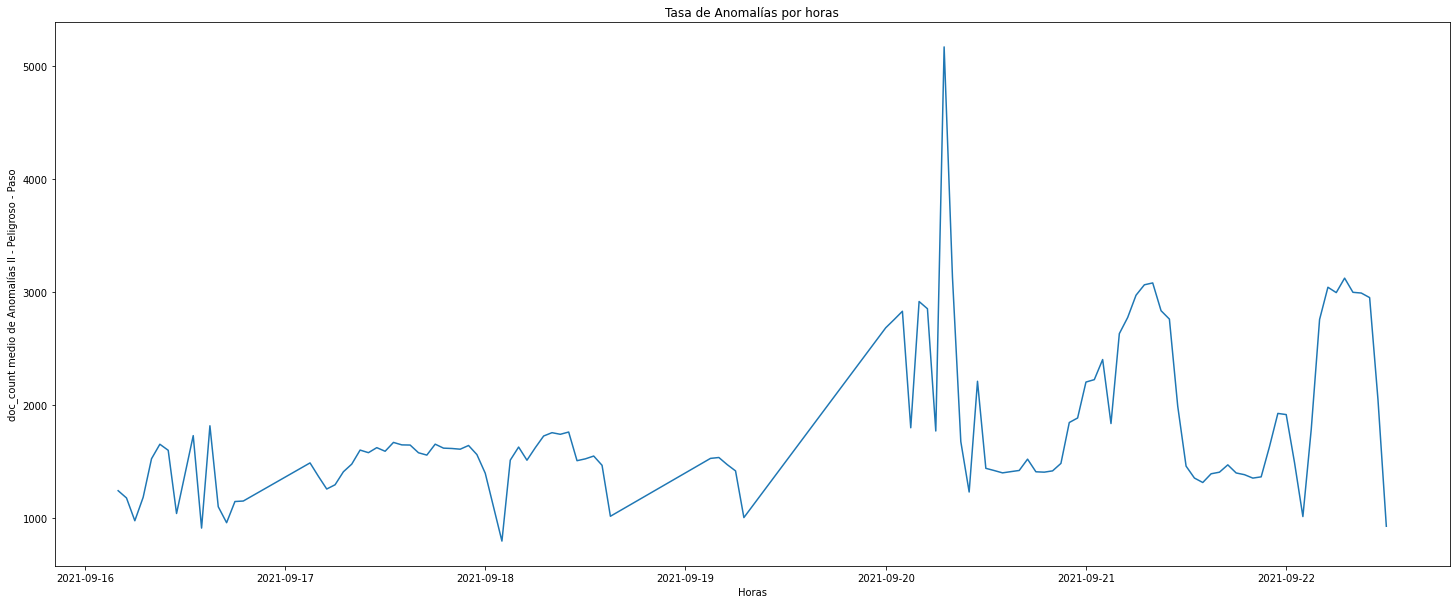

In [54]:
plt.figure(figsize=(25,10))
plt.plot(wd1[wd1['anomaly']==-1]['doc_count'].groupby('Fecha').mean())
plt.title('Tasa de Anomalías por horas')
plt.xlabel('Horas')
plt.ylabel('doc_count medio de Anomalías II - Peligroso - Paso')

### Hagamos un análisis descriptivo de las anomalías para ver que podemos descubrir, pero para esto debemos volver a los datos originales

In [55]:
anomaly_data1 = wd1[wd1['anomaly']==-1]
anomaly_data1 = anomaly_data1.reset_index()
lista = anomaly_data1['aux_indx'].to_list()
data_describe = df1.loc[lista]

In [56]:
data_describe['Port Lvl'].value_counts()

Seguro       26250
Peligroso    10788
Name: Port Lvl, dtype: int64

In [57]:
data_describe['Action'].value_counts()

Paso       36345
No Paso      693
Name: Action, dtype: int64

In [58]:
data_describe['doc_count'].describe()

count    37038.000000
mean      1597.802851
std       1834.516193
min        611.000000
25%        819.000000
50%       1202.000000
75%       1420.000000
max      77143.000000
Name: doc_count, dtype: float64

In [59]:
data_describe['IP Origen'].value_counts()

10.100.5.187    10803
10.100.5.188    10796
10.20.24.91      1005
10.100.5.136      968
10.20.1.10        557
                ...  
10.200.0.165        1
10.200.2.84         1
10.200.2.144        1
10.15.17.164        1
10.200.8.14         1
Name: IP Origen, Length: 1017, dtype: int64

## Veamos de donde vienen estos comportamientos anomalos

<AxesSubplot:xlabel='count', ylabel='IP Origen'>

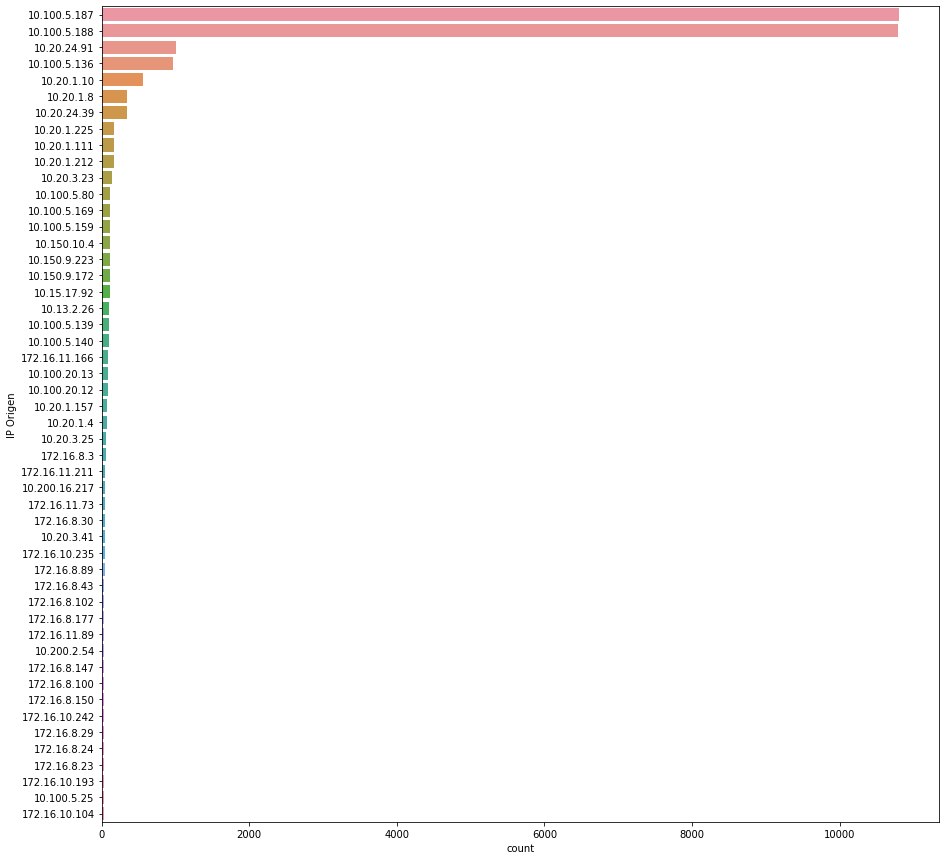

In [60]:

plt.figure(figsize=(15,15))
sns.countplot(y='IP Origen', data = data_describe,
             order = data_describe['IP Origen'].value_counts().iloc[:50].index)

## Y a donde van

<AxesSubplot:xlabel='count', ylabel='IP Destino'>

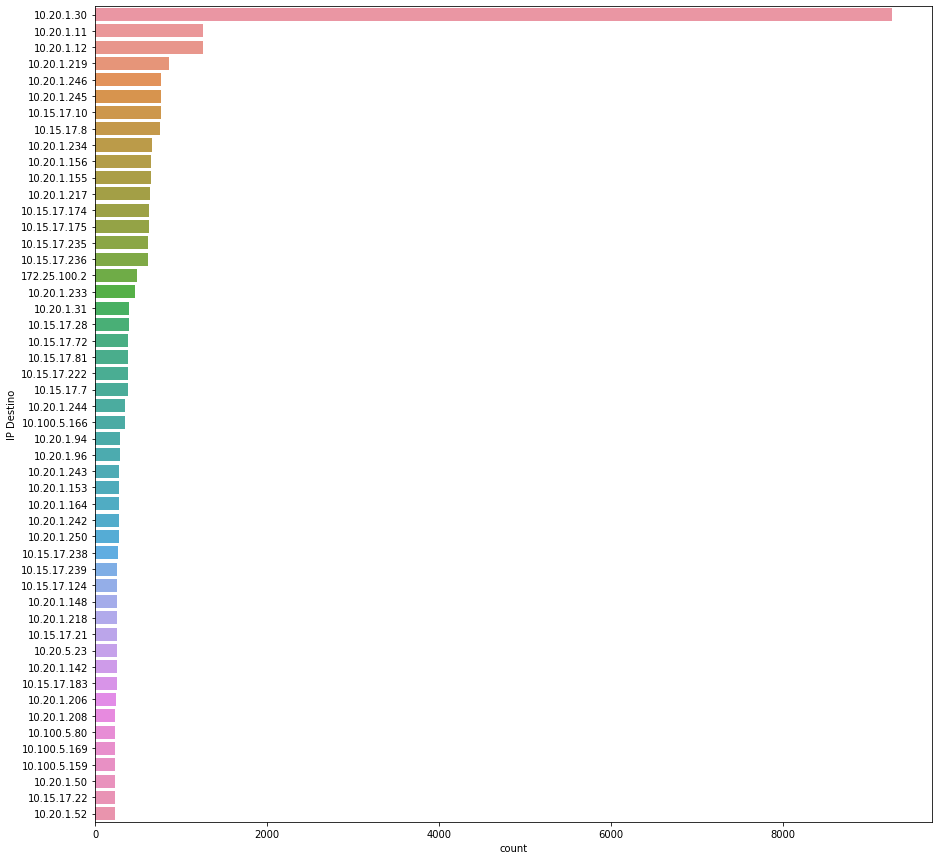

In [61]:
plt.figure(figsize=(15,15))
sns.countplot(y='IP Destino', data = data_describe,
             order = data_describe['IP Destino'].value_counts().iloc[:50].index)

## Con lo anterior podemos notar que si hay un umbral que podemos inferir al menos para los datos de Interno a interno!

# Podemos obtener resultados similares con mas variables? Intentemos KMeans para variables mixtas, Kmodes

In [203]:
from kmodes.kprototypes import KPrototypes

In [204]:
wd_kmodes = df1[['Action', 'Port Lvl', 'doc_count', 'aux_indx']]

In [213]:
wd_kmodes.values[2:]

array([['Paso', 'Seguro', 5, 108],
       ['No Paso', 'Seguro', 2, 109],
       ['No Paso', 'Peligroso', 2, 110],
       ...,
       ['No Paso', 'Seguro', 3, 7084623],
       ['Paso', 'Seguro', 1, 7084624],
       ['Paso', 'Seguro', 1, 7084625]], dtype=object)

In [212]:
categorical_features_idx = [0, 1]
mark_array = wd_kmodes.values[2:]

In [215]:
kproto = KPrototypes(n_clusters=2, verbose=2, max_iter=20).fit(mark_array, categorical=categorical_features_idx)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 116033, ncost: 1.0689214399618232e+18
Run: 1, iteration: 2/20, moves: 48920, ncost: 1.0063643994577658e+18
Run: 1, iteration: 3/20, moves: 37232, ncost: 9.7040308771472e+17
Run: 1, iteration: 4/20, moves: 35293, ncost: 9.436346532245514e+17
Run: 1, iteration: 5/20, moves: 19660, ncost: 9.342530135533966e+17
Run: 1, iteration: 6/20, moves: 19118, ncost: 9.27576414110812e+17
Run: 1, iteration: 7/20, moves: 4145, ncost: 9.27233143809666e+17
Run: 1, iteration: 8/20, moves: 4322, ncost: 9.25679733679044e+17
Run: 1, iteration: 9/20, moves: 13499, ncost: 9.224601450921468e+17
Run: 1, iteration: 10/20, moves: 3226, ncost: 9.222834495620609e+17
Run: 1, iteration: 11/20, moves: 0, ncost: 9.222834495620609e+17
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 55116, nco

### Hagamonos una idea de los centroides del modelo

In [216]:
print(kproto.cluster_centroids_)

[['109.92866153088036' '5008971.917422797' 'Paso' 'Seguro']
 ['181.1613574256212' '1381771.1320488332' 'Paso' 'Seguro']]


#### Prediciendo Clusters

In [228]:
clusters = kproto.predict(mark_array, categorical=categorical_features_idx)

In [229]:
lista_cluster = list(clusters)
lista_cluster.append(1)
lista_cluster.append(0)

In [230]:
wd_kmodes['Clusters'] = lista_cluster

### Describamos que pasa con los Clusters

In [231]:
wd_kmodes['Clusters'].value_counts()

0    525594
1    252862
Name: Clusters, dtype: int64

In [235]:
wd_kmodes[wd_kmodes['Clusters']==0]['Port Lvl'].value_counts()

Seguro       362540
Peligroso    163054
Name: Port Lvl, dtype: int64

In [236]:
wd_kmodes[wd_kmodes['Clusters']==1]['Port Lvl'].value_counts()

Seguro       178396
Peligroso     74466
Name: Port Lvl, dtype: int64

In [242]:
wd_kmodes[wd_kmodes['Clusters']==0]['Action'].value_counts()

Paso       492621
No Paso     32973
Name: Action, dtype: int64

In [243]:
wd_kmodes[wd_kmodes['Clusters']==1]['Action'].value_counts()

Paso       231027
No Paso     21835
Name: Action, dtype: int64

### Y si vemos los datos originales? Como se relaciona con las anomalías encontradas antes? 

In [1]:
wd_kmodes.loc[lista]['Clusters'].value_counts()

NameError: name 'wd_kmodes' is not defined

### Al parecer los Clusters no son un buen predictor de las anomalías según habiamos revisado antes, probemos otro tipo de clusterización ahora a ver que tal resulta. 

In [ ]:
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
wd_PCA = df1[['Action', 'Port Lvl', 'doc_count', 'aux_indx']]
dataX = wd_PCA.copy().drop(['aux_indx'], axis=1)
dataY = wd_PCA['doc_count'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=42, stratify=dataY)